In [12]:
from pathlib import Path
import xml.etree.ElementTree as ET

log_dir = Path("logs")
log_files = list(sorted(log_dir.glob('*.xml')))
print(len(log_files))

errored = 0
source_dir = Path("mini_Project_CodeNet")
for log_file in log_files:
    try:
        tree = ET.parse(log_file)
        trace = tree.getroot()
    except Exception as e:
        errored += 1
        print('Error', log_file, e)
print(f'{errored=}')

2835
Error logs/c-p02256-s143083472.xml no element found: line 130, column 0
Error logs/c-p02407-s199145526.xml not well-formed (invalid token): line 134, column 8
Error logs/c-p02407-s211137776.xml not well-formed (invalid token): line 162, column 8
Error logs/c-p02407-s216704067.xml not well-formed (invalid token): line 150, column 8
Error logs/c-p02407-s985047890.xml no element found: line 151, column 0
Error logs/c-p02971-s007487668.xml mismatched tag: line 10, column 2
Error logs/c-p03242-s463688387.xml not well-formed (invalid token): line 57, column 10
Error logs/c-p04030-s112171048.xml not well-formed (invalid token): line 121, column 8
Error logs/c-p04030-s236519665.xml not well-formed (invalid token): line 224, column 10
Error logs/c-p04030-s290932125.xml not well-formed (invalid token): line 85, column 8
Error logs/c-p04030-s358709174.xml no element found: line 237, column 0
Error logs/c-p04030-s360235307.xml no element found: line 156, column 0
Error logs/c-p04030-s40205651

In [15]:
import xml.etree.ElementTree as ET

sequences = []
skipped = 0
errored = 0

for log_file in log_files:
    tokens = ['<CODE>']

    c_cpp, problem, solution = log_file.stem.split('-')
    c_cpp_pathelement = 'C' if c_cpp == 'c' else 'C++'
    source_file = source_dir / problem / c_cpp_pathelement / (solution + '.' + c_cpp)
    with open(source_file) as f:
        lines = f.readlines()
    lines = [l + f'/*L{i}*/' for i, l in enumerate(lines)]
    tokens += ''.join(lines).split()

    try:
        # Map line number to data
        state = {}
        output = {}

        tree = ET.parse(log_file)
        trace = tree.getroot()
        for child in trace:
            if child.tag == 'program_point':
                filename = child.attrib["filename"]
                lineno = child.attrib["line"]
                state[lineno] = my_state = []
                for variable in child:
                    if variable.tag == 'variable':
                        my_state.append((variable.attrib["name"], variable.text))
                    elif variable.tag == 'stdout':
                        output[lineno] = variable.text
            elif child.tag == 'stdout':
                output[lineno] = child.text
        tokens.append('<STATE>')
        for lineno, states in state.items():
            tokens.append(f'L{lineno}')
            for variable in states:
                name, text = variable
                tokens += [name, text]
        tokens.append('<OUTPUT>')
        for lineno, outputs in output.items():
            tokens.append(f'L{lineno}')
            tokens.append('"' + outputs.replace('\n', '\\n') + '"')
    except Exception as e:
        print('Error', log_file, e)
        errored += 1
        continue
    tokens.append('<END>')

    trunc = 100
    tokens = [tok[:trunc] for tok in tokens]
    
    if (len(tokens) < 1000):
        sequences.append(tokens)
    else:
        skipped += 1
print(skipped, 'skipped', errored, 'errored out')

Error logs/c-p02256-s143083472.xml no element found: line 130, column 0
Error logs/c-p02407-s199145526.xml not well-formed (invalid token): line 134, column 8
Error logs/c-p02407-s211137776.xml not well-formed (invalid token): line 162, column 8
Error logs/c-p02407-s216704067.xml not well-formed (invalid token): line 150, column 8
Error logs/c-p02407-s985047890.xml no element found: line 151, column 0
Error logs/c-p02971-s007487668.xml mismatched tag: line 10, column 2
Error logs/c-p03242-s463688387.xml not well-formed (invalid token): line 57, column 10
Error logs/c-p04030-s112171048.xml not well-formed (invalid token): line 121, column 8
Error logs/c-p04030-s236519665.xml not well-formed (invalid token): line 224, column 10
Error logs/c-p04030-s290932125.xml not well-formed (invalid token): line 85, column 8
Error logs/c-p04030-s358709174.xml no element found: line 237, column 0
Error logs/c-p04030-s360235307.xml no element found: line 156, column 0
Error logs/c-p04030-s402056511.xml

In [16]:
from collections import defaultdict
from matplotlib import pyplot as plt

print('number of sequences:', len(sequences))
seq_lengths = defaultdict(int)
token_lengths = defaultdict(int)
code_lengths = defaultdict(int)
state_lengths = defaultdict(int)
output_lengths = defaultdict(int)
for seq in sequences:
    seq_lengths[len(seq)] += 1
    code_lengths[seq.index('<STATE>') - seq.index('<CODE>')-1] += 1
    state_lengths[seq.index('<OUTPUT>') - seq.index('<STATE>')-1] += 1
    output_lengths[seq.index('<END>') - seq.index('<OUTPUT>')-1] += 1
    for tok in seq:
        token_lengths[len(tok)] += 1

# print(code_lengths, state_lengths, output_lengths)

def get_avg(dd):
    long = []
    for l, f in dd.items():
        long += [l] * f
    return sum(long) / len(long)

print('average token length:', get_avg(token_lengths))
print('average sequence length:', get_avg(seq_lengths))
print('average code length:', get_avg(code_lengths))
print('average state length:', get_avg(state_lengths))
print('average output length:', get_avg(output_lengths))

number of sequences: 2784
average token length: 6.367056794795681
average sequence length: 171.2216235632184
average code length: 80.1882183908046
average state length: 84.5959051724138
average output length: 2.4375


Text(0.5, 1.0, 'Token length (capped at 100)')

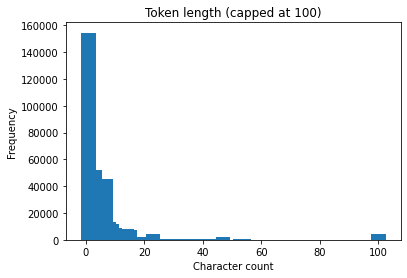

In [17]:
plt.bar(token_lengths.keys(), token_lengths.values(), width=5)
plt.xlabel('Character count')
plt.ylabel('Frequency')
plt.title('Token length (capped at 100)')

Text(0.5, 1.0, 'Sequence length (capped at 1000)')

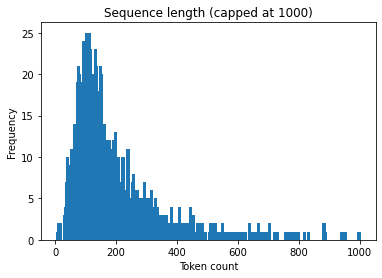

In [18]:
plt.bar(seq_lengths.keys(), seq_lengths.values(), width=10)
plt.xlabel('Token count')
plt.ylabel('Frequency')
plt.title('Sequence length (capped at 1000)')

Text(0.5, 1.0, 'Code sequence length')

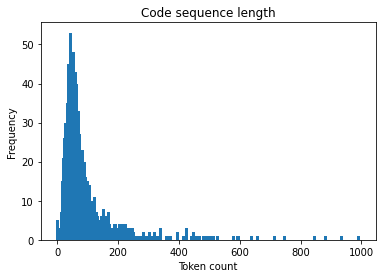

In [19]:
plt.bar(code_lengths.keys(), code_lengths.values(), width=10)
plt.xlabel('Token count')
plt.ylabel('Frequency')
plt.title('Code sequence length')

Text(0.5, 1.0, 'State sequence length')

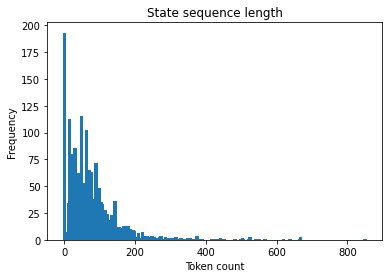

In [20]:
plt.bar(state_lengths.keys(), state_lengths.values(), width=10)
plt.xlabel('Token count')
plt.ylabel('Frequency')
plt.title('State sequence length')

Text(0.5, 1.0, 'Output sequence length')

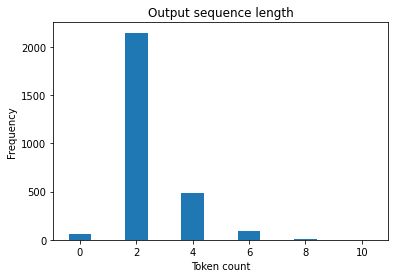

In [21]:
plt.bar(output_lengths.keys(), output_lengths.values())
plt.xlabel('Token count')
plt.ylabel('Frequency')
plt.title('Output sequence length')

In [22]:
import random
for i in range(3):
    seq = random.choice(sequences)
    print(' '.join(seq), end='\n\n')

<CODE> #include <iostream> /*L0*/#include <vector> /*L1*/#include <algorithm> /*L2*/#include <queue> /*L3*/#include <cstring> /*L4*/#include <cstdio> /*L5*/#include <cmath> /*L6*/#include <set> /*L7*/#include <map> /*L8*/#include <bitset> /*L9*/#include <deque> /*L10*/#define rep(i,n) for (int i = 0; i < (n); i++) /*L11*/using namespace std; /*L12*/using ll = long long; /*L13*/using itn = int; /*L14*/const ll MOD = 1000000007; /*L15*/const ll INF = MOD * MOD; /*L16*/ /*L17*/int main() { /*L18*/ /*L19*/ int n; /*L20*/ cin >> n; /*L21*/ /*L22*/ int ma1 = 0; /*L23*/ int ma2 = 0; /*L24*/ /*L25*/ vector<int> a(n); /*L26*/ for (int i = 0; i < n; i++) { /*L27*/ cin >> a[i]; /*L28*/ if (ma1 < a[i]) ma1 = a[i]; /*L29*/ if (ma2 < a[i]) /*L30*/ if (ma1 >= a[i]) ma2 = a[i]; /*L31*/ } /*L32*/ /*L33*/ int tmp = 0; /*L34*/ /*L35*/ for (int i = 0; i < n; i++) { /*L36*/ tmp = 0; /*L37*/ if(a[i] != ma1) cout << ma1 << endl; /*L38*/ else cout << ma2 << endl; /*L39*/ } /*L40*/ /*L41*/ return 0; /*L42*/ /*

In [23]:
with open('sequences.txt', 'w') as f:
    f.writelines([' '.join(' '.join(seq).split()) + '\n' for seq in sequences])